In [1]:
# start a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ALS100").config("spark.driver.memory", "16g").getOrCreate()

24/04/24 20:15:17 WARN Utils: Your hostname, ZOU.local resolves to a loopback address: 127.0.0.1; using 100.72.44.48 instead (on interface en0)
24/04/24 20:15:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/24 20:15:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# set the log level to ERROR
spark.sparkContext.setLogLevel("ERROR")

In [3]:
# read parquet files
best_predictions = spark.read.parquet("/Users/ZOU/best_predictions_100.parquet")

In [4]:
best_predictions.show(5)

+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+----------+
|            business|                user|rating|       avg_rating|num_of_reviews|rating_binary|business_id|user_id|prediction|
+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+----------+
|0x7c006dede4a406b...|11658072799814822...|   5.0|4.199999809265137|          5279|            1|        6.0| 2999.0| 0.6641859|
|0x7c006dede4a406b...|10869535853280851...|   4.0|4.199999809265137|          5279|            0|        6.0|11316.0|0.57736874|
|0x7c006dede4a406b...|10174168442722586...|   4.0|4.199999809265137|          5279|            0|        6.0|21598.0|0.36146125|
|0x7c006dede4a406b...|11357409489876479...|   5.0|4.199999809265137|          5279|            1|        6.0|92858.0|0.37051246|
|0x7c006dede4a406b...|10558305043179426...|   5.0|4.199999809265137|          5279|            1|

In [5]:
from pyspark.sql.functions import when, col

# define a function to evaluate the model
def evaluate_model(predictions):
    # calculate TP, FP, TN, FN
    TP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 1)).count()
    FP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 0)).count()
    TN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 0)).count()
    FN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 1)).count()

    # calculate Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    # calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) else 0

    return accuracy, precision, recall, f1_score, specificity

In [6]:
best_predictions = best_predictions.withColumn('prediction_binary', when(col('prediction') > 0, 1).otherwise(0))
accuracy, precision, recall, f1_score, specificity = evaluate_model(best_predictions)
print("The accuracy of the ALS model is:", accuracy)
print("The precision of the ALS model is:", precision)
print("The recall of the ALS model is:", recall)
print("The f1_score of the ALS model is:", f1_score)
print("The specificity of the ALS model is:", specificity)

The accuracy of the ALS model is: 0.6587070275136443
The precision of the ALS model is: 0.663004675951531
The recall of the ALS model is: 0.9374566782191416
The f1_score of the ALS model is: 0.7766987431987691
The specificity of the ALS model is: 0.17760736196319019


In [7]:
# normalize the 'prediction' into 0-1

max_prediction = best_predictions.agg({"prediction": "max"}).collect()[0][0]
min_prediction = best_predictions.agg({"prediction": "min"}).collect()[0][0]

best_predictions = best_predictions.withColumn("probability", (best_predictions["prediction"] - min_prediction) / (max_prediction - min_prediction))

best_predictions.show(5)

+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+----------+-----------------+-------------------+
|            business|                user|rating|       avg_rating|num_of_reviews|rating_binary|business_id|user_id|prediction|prediction_binary|        probability|
+--------------------+--------------------+------+-----------------+--------------+-------------+-----------+-------+----------+-----------------+-------------------+
|0x7c006dede4a406b...|11658072799814822...|   5.0|4.199999809265137|          5279|            1|        6.0| 2999.0| 0.6641859|                1| 0.6918956587813208|
|0x7c006dede4a406b...|10869535853280851...|   4.0|4.199999809265137|          5279|            0|        6.0|11316.0|0.57736874|                1| 0.6266076535355098|
|0x7c006dede4a406b...|10174168442722586...|   4.0|4.199999809265137|          5279|            0|        6.0|21598.0|0.36146125|                1|  0.464241465259076

In [9]:
# best_predictions.write.parquet("/Users/ZOU/best_predictions_100_probability.parquet")

In [10]:
import pandas as pd
best_predictions_pd = pd.read_parquet("/Users/ZOU/best_predictions_100_probability.parquet")

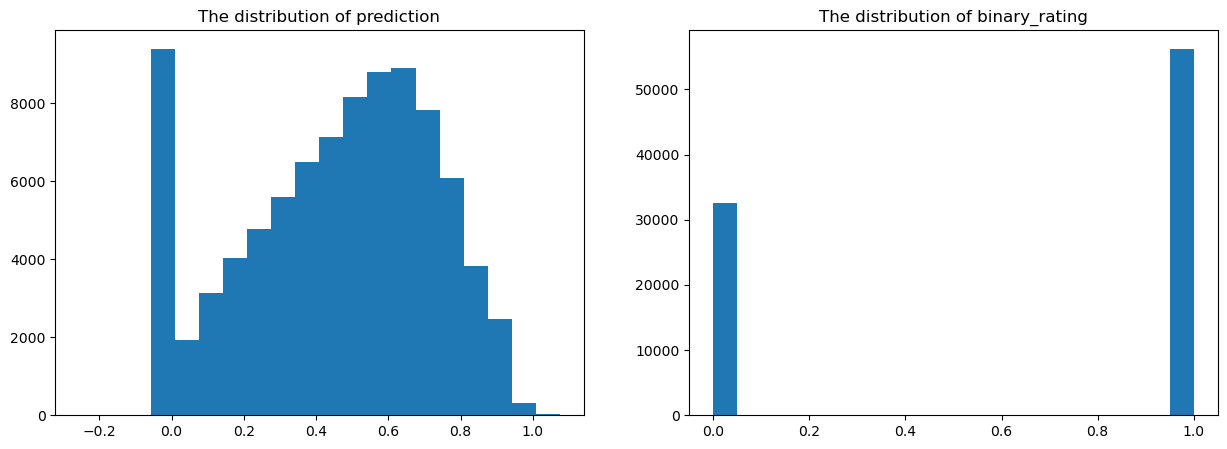

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the ditrbution of prediction column
axs[0].hist(best_predictions_pd["prediction"], bins=20)
axs[0].set_title("The distribution of prediction")

# draw the ditrbution of rating column
axs[1].hist(best_predictions_pd["rating_binary"], bins=20)
axs[1].set_title("The distribution of binary_rating")

plt.show()

In [12]:
# draw the precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])
auc_score_pr = auc(recall, precision)

# calculate the roc curve
fpr, tpr, _ = roc_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the auc
auc_score = auc(fpr, tpr)

print(auc_score_pr)
print(auc_score)

0.8570787467909331
0.7775187464665183


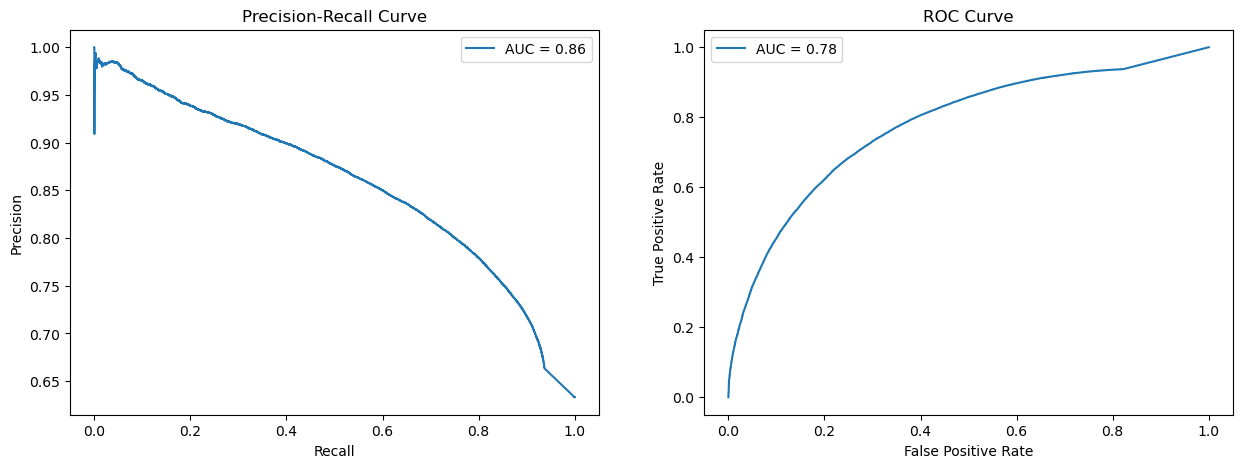

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the precision-recall curve
axs[0].plot(recall, precision, label="AUC = {:.2f}".format(auc_score_pr))
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve")
axs[0].legend()

# draw the roc curve
axs[1].plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()

plt.show()